# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_il_other, get_and_process_covidtracking_data_il_contact, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))
df_other = get_and_process_covidtracking_data_il_other(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))
df_contact = get_and_process_covidtracking_data_il_contact(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))


In [3]:
region = "Israel"
model_data = df.loc[region]
model_data_other = df_other.loc[region]
model_data_contact = df_contact.loc[region]

## Create the model instance and sample

In [4]:
gm = GenerativeModel(region, model_data)
gm.sample()
gm_other = GenerativeModel(region, model_data_other)
gm_other.sample()
gm_contact = GenerativeModel(region, model_data_contact)
gm_contact.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2501 seconds.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1763 seconds.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1796 seconds.


## Summarize Model Output

In [5]:
result = summarize_inference_data(gm.inference_data)
result_other = summarize_inference_data(gm_other.inference_data)
result_contact = summarize_inference_data(gm_contact.inference_data)

In [6]:
result.tail(21)

result_contact.tail(21)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-03,1.028340,1.024787,0.928413,1.141127,254.829392,277.635277,280.948131,373.0,405
2020-07-04,1.028528,1.022625,0.916020,1.140232,256.161561,279.283409,253.004318,175.0,211
2020-07-05,1.027194,1.021076,0.910890,1.146325,257.561547,280.887895,271.973110,444.0,498
2020-07-06,1.026678,1.019500,0.906786,1.153170,259.003238,282.454749,274.870844,592.0,657
2020-07-07,1.026215,1.016340,0.897099,1.151476,260.461385,283.989224,276.988314,533.0,587
2020-07-08,1.028649,1.018862,0.895516,1.150960,261.936654,285.498424,279.349116,663.0,724
2020-07-09,1.028824,1.018570,0.894379,1.160132,263.457954,286.992612,282.384598,598.0,646
2020-07-10,1.029892,1.020189,0.856916,1.144332,265.109255,288.485244,268.926469,469.0,532
2020-07-11,1.030002,1.022667,0.875690,1.174984,266.909217,289.989002,275.843917,255.0,282


## Plot Model Output

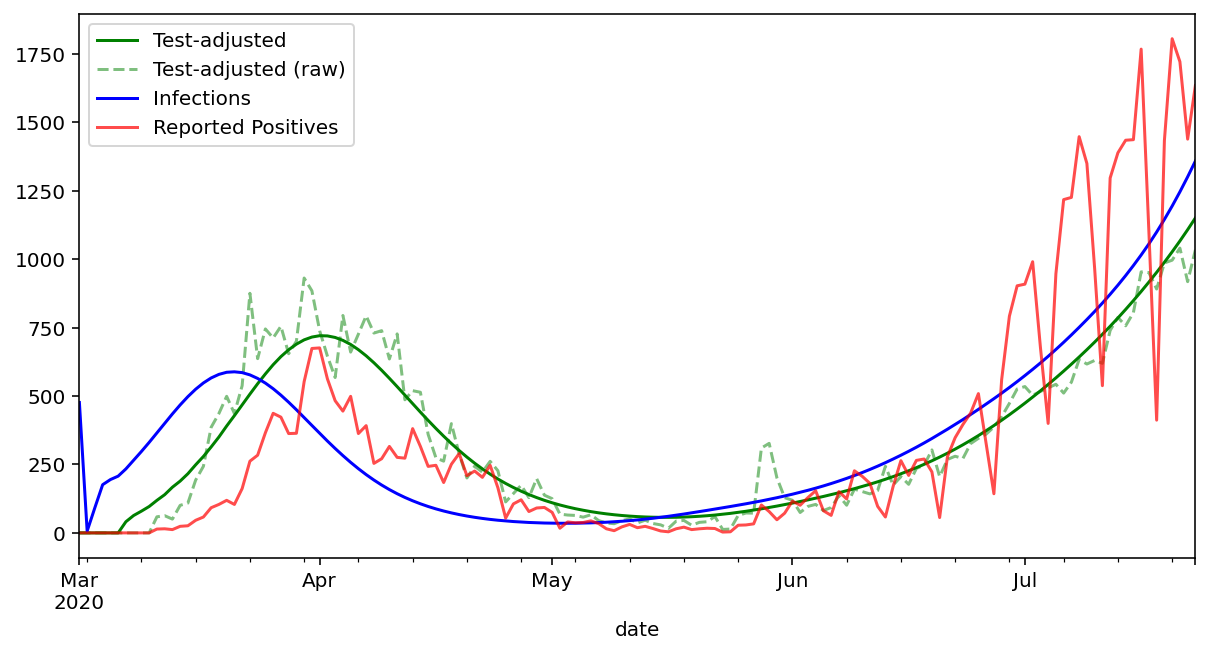

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

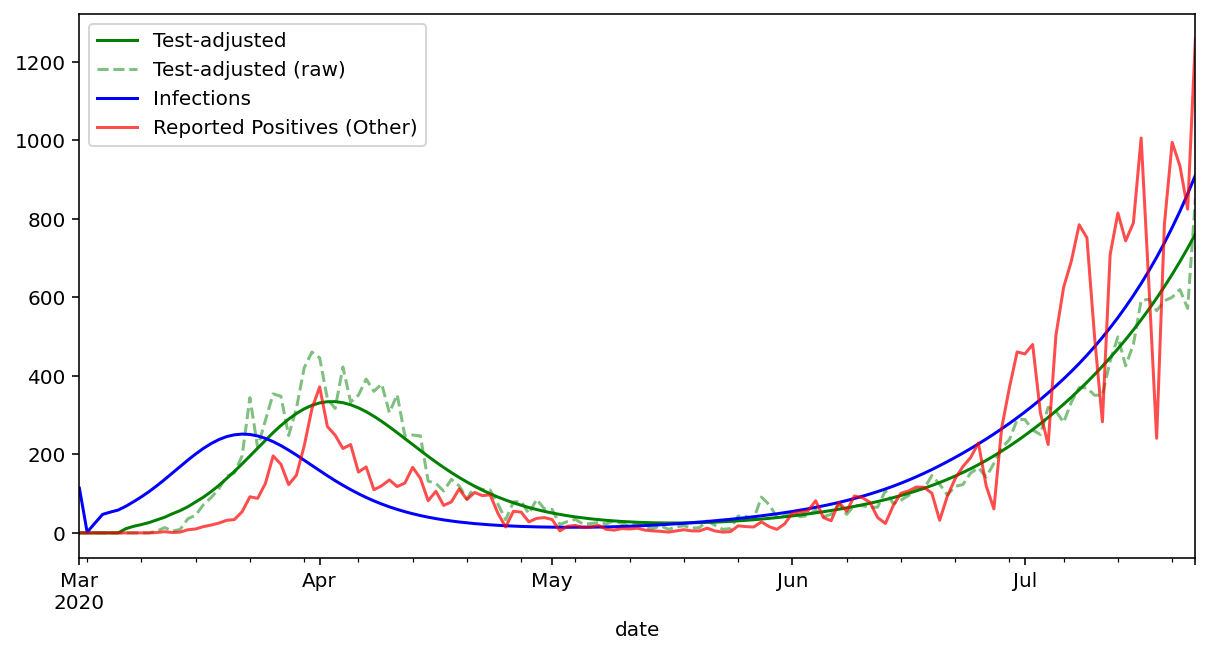

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
result_other.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result_other.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result_other.infections.plot(c="b", label="Infections")
gm_other.observed.positive.plot(c='r', alpha=.7, label="Reported Positives (Other)")
fig.set_facecolor('w')
ax.legend();

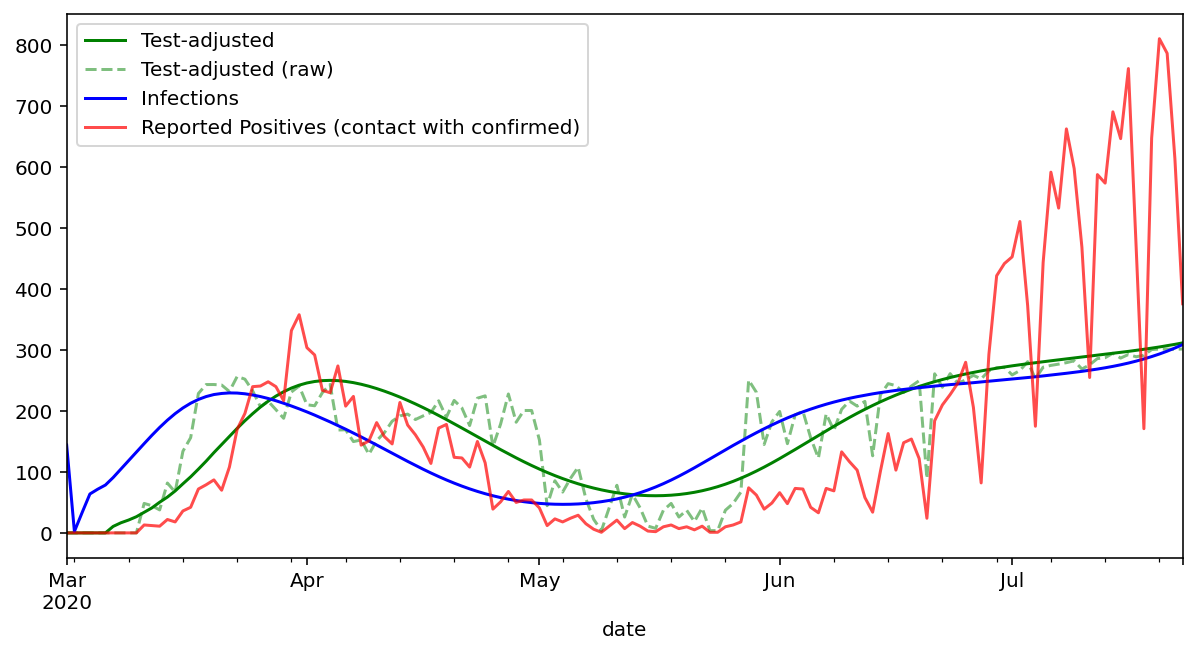

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
result_contact.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result_contact.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result_contact.infections.plot(c="b", label="Infections")
gm_contact.observed.positive.plot(c='r', alpha=.7, label="Reported Positives (contact with confirmed)")
fig.set_facecolor('w')
ax.legend();

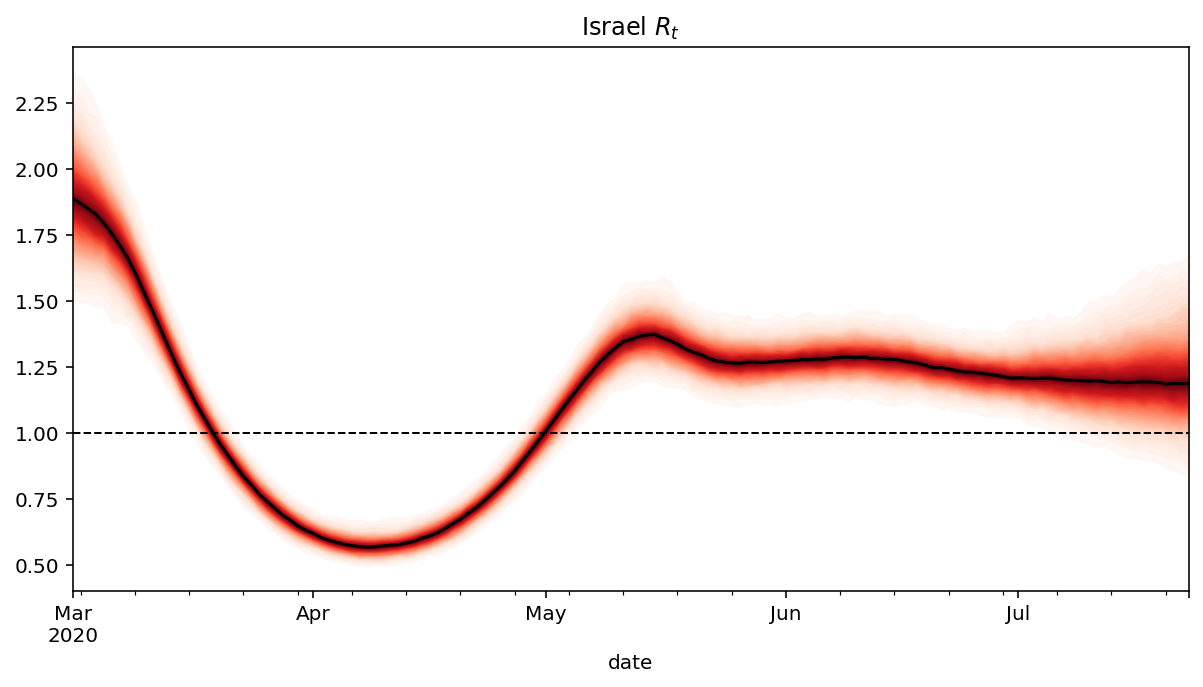

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')

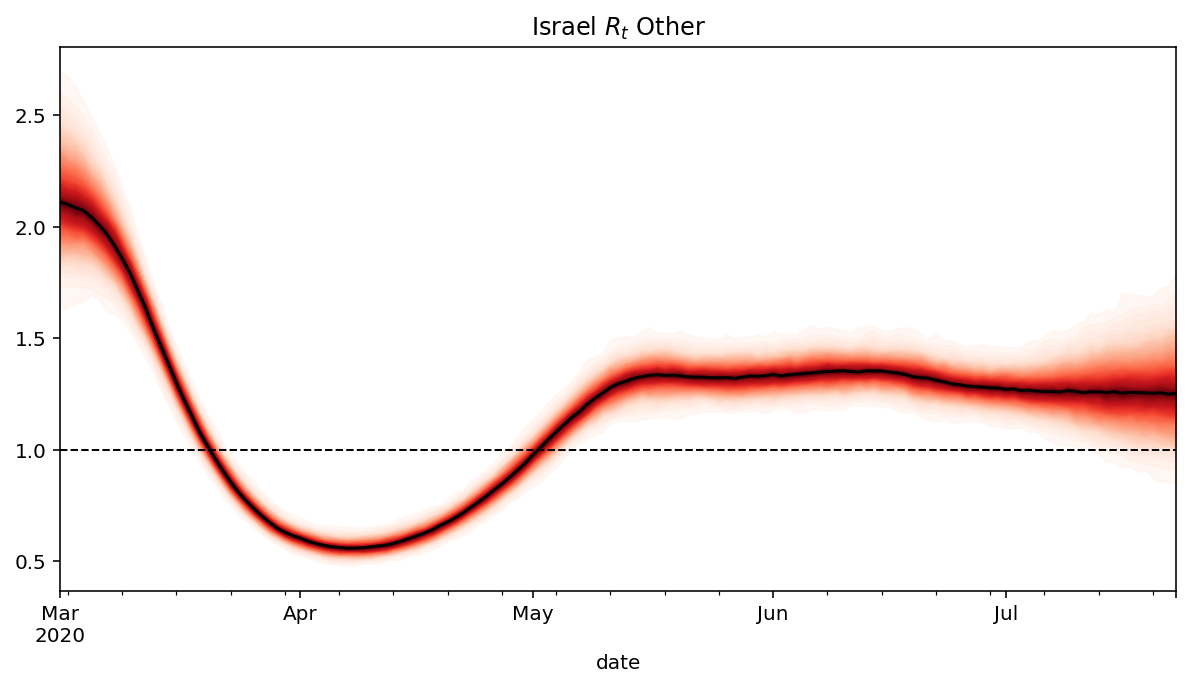

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$ Other")
samples = gm_other.trace['r_t']
x=result_other.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result_other["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')

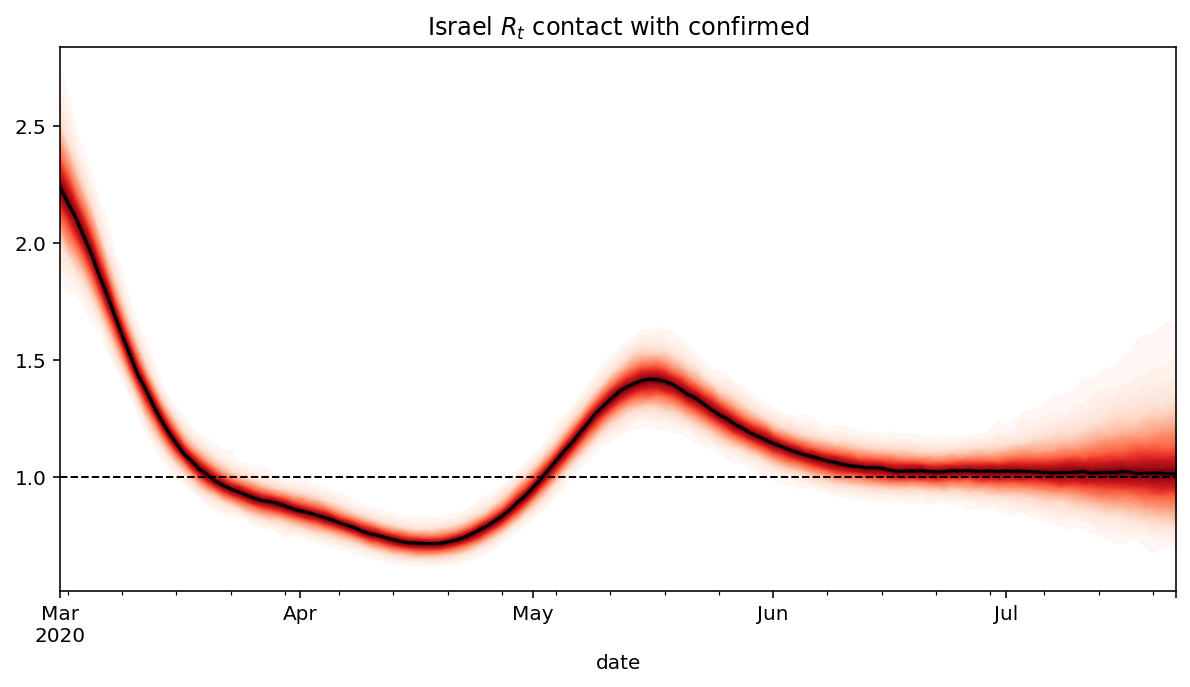

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$ contact with confirmed")
samples = gm_contact.trace['r_t']
x=result_contact.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result_contact["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')

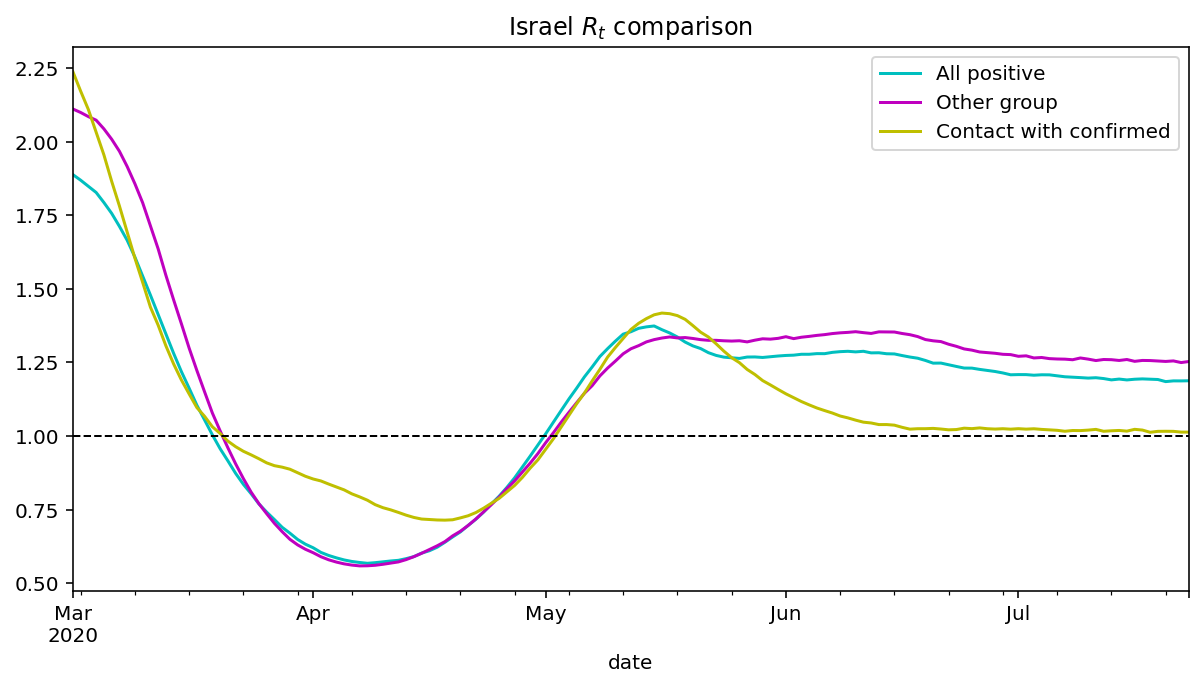

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$ comparison")
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

result["median"].plot(c="c", ls='-', label="All positive")
result_other["median"].plot(c="m", ls='-', label="Other group")
result_contact["median"].plot(c="y", ls='-', label="Contact with confirmed")

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')
ax.legend()

In [14]:
result_other.tail(21)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-03,1.269403,1.265325,1.168758,1.375975,339.859647,278.293639,250.682991,306.0,12193
2020-07-04,1.267013,1.266898,1.154456,1.374635,356.714541,294.171095,319.972041,225.0,7024
2020-07-05,1.266202,1.263037,1.142534,1.371827,374.243026,310.693941,309.745051,503.0,16221
2020-07-06,1.266709,1.261793,1.148532,1.388998,392.464040,327.879639,281.653928,626.0,22201
2020-07-07,1.265839,1.261248,1.131198,1.386206,411.491730,345.745861,333.570236,693.0,20752
2020-07-08,1.266846,1.259253,1.116913,1.388679,431.480170,364.320134,370.200680,785.0,21181
2020-07-09,1.268224,1.265253,1.116716,1.402753,452.504286,383.637259,369.501189,752.0,20329
2020-07-10,1.264161,1.261364,1.085846,1.388229,474.654680,403.732912,350.447662,497.0,14166
2020-07-11,1.265065,1.256502,1.080008,1.400037,498.067233,424.641007,351.508946,283.0,8042
